In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 2. Outlier Removal (The "Clean-up")
# Remove houses with > 4000 sqft that sold for < $300,000 (The "weird" ones)
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

# 3. Log-Transformation (The "Normalization")
# We apply log(1+x) to the target to fix skewness
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
y = train_df['SalePrice']
X = train_df.drop(['SalePrice', 'Id'], axis=1)

print("Step 1 Complete: Outliers removed and Target Variable log-transformed.")

Step 1 Complete: Outliers removed and Target Variable log-transformed.


In [2]:
# 1. Feature Engineering Function
def engineer_features(df):
    # Create 'TotalSF' (Total Square Footage)
    # Fill NAs with 0 before adding to avoid errors
    df['TotalSF'] = (df['TotalBsmtSF'].fillna(0) + 
                     df['1stFlrSF'].fillna(0) + 
                     df['2ndFlrSF'].fillna(0))
    
    # Optional: Create 'HouseAge'
    df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    return df

# Apply to X (Train) and test_df (Submission data)
X = engineer_features(X)
test_df = engineer_features(test_df)

# 2. Advanced Preprocessing Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define "Numeric" and "Categorical" features again (since we added TotalSF)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Numeric Transformer: Handle missing numeric values with Median
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Handle missing categories as "None" (e.g., No Pool)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Step 2 Complete: New features created and Preprocessor defined.")

Step 2 Complete: New features created and Preprocessor defined.


NameError: name 'y' is not defined

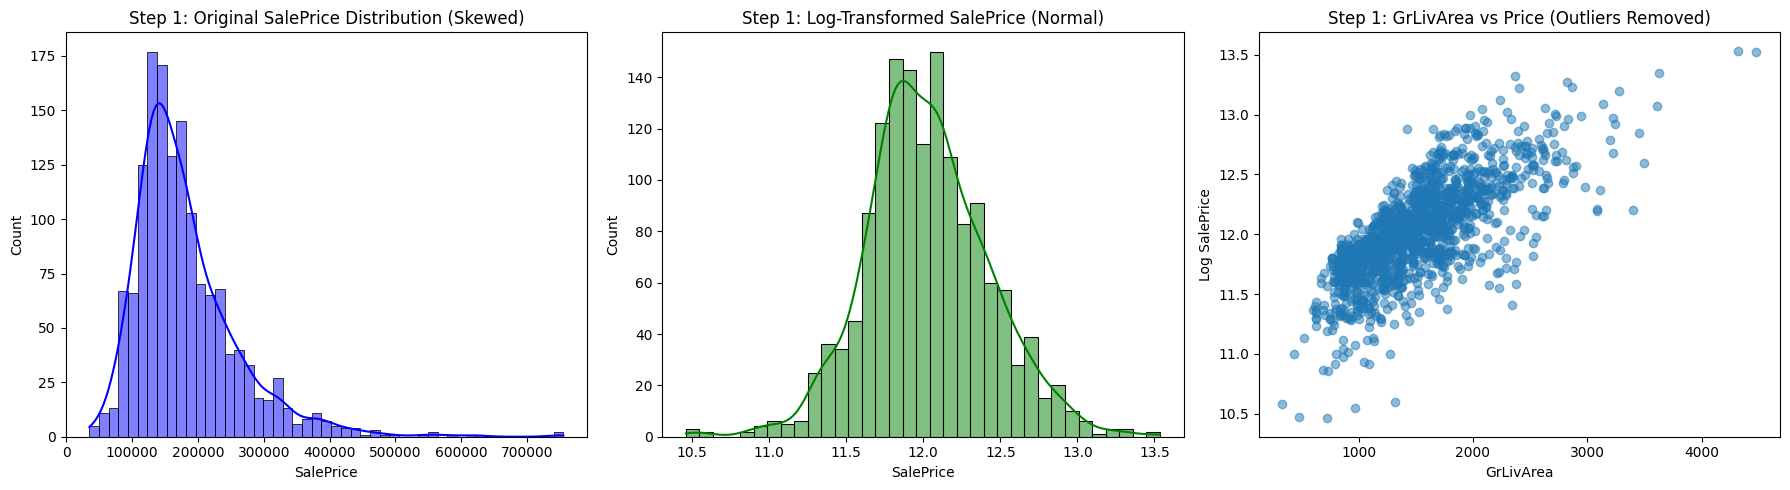

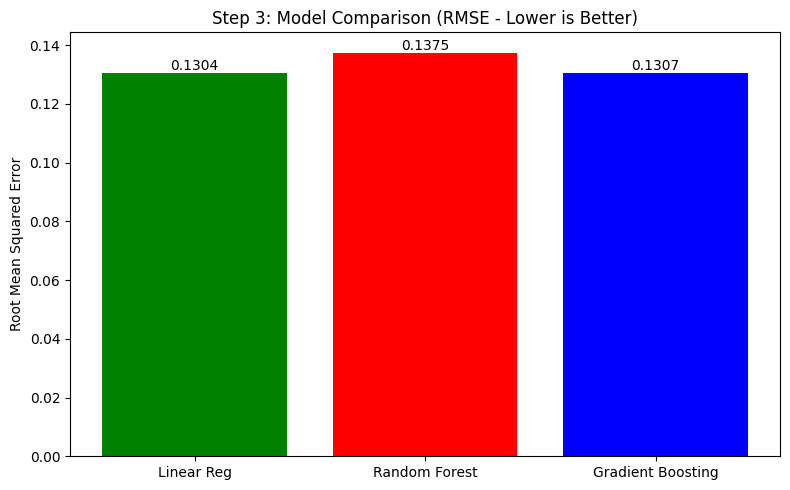

C:\Users\samwe\AppData\Local\Temp\ipykernel_14668\978239734.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[top_indices], y=feature_names[top_indices], palette='viridis')


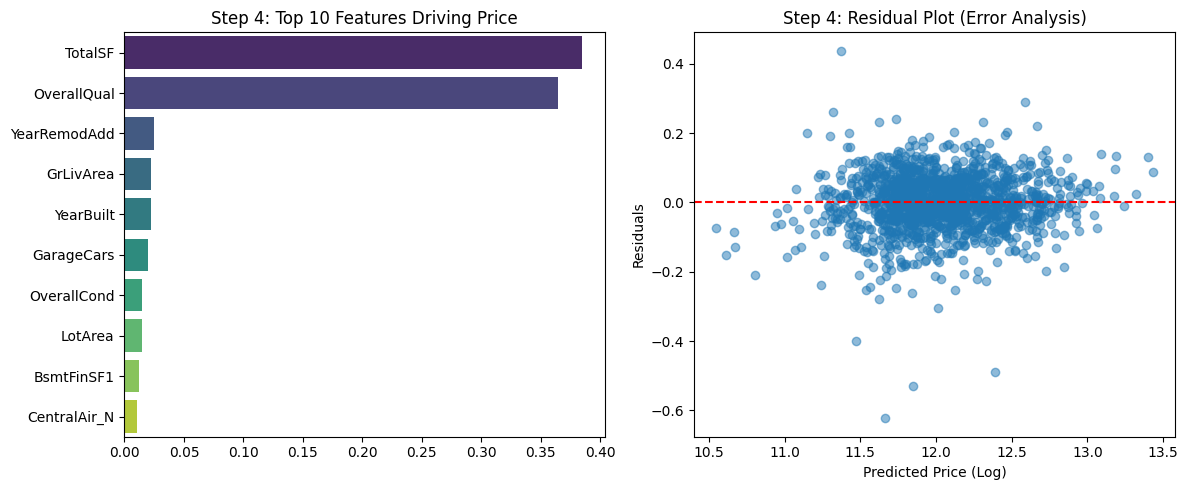

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# --- 1. Load & Prepare Data ---
train_df = pd.read_csv('train.csv')

# --- 2. Step 1 Visualizations: EDA (Target & Outliers) ---
plt.figure(figsize=(18, 5))

# Plot A: Original Distribution
plt.subplot(1, 3, 1)
sns.histplot(train_df['SalePrice'], kde=True, color='blue')
plt.title('Step 1: Original SalePrice Distribution (Skewed)')

# Remove Outliers for subsequent plots
train_df_clean = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

# Plot B: Log-Transformed Distribution
plt.subplot(1, 3, 2)
sns.histplot(np.log1p(train_df_clean['SalePrice']), kde=True, color='green')
plt.title('Step 1: Log-Transformed SalePrice (Normal)')

# Plot C: Outlier Check (Post-Removal)
plt.subplot(1, 3, 3)
plt.scatter(train_df_clean['GrLivArea'], np.log1p(train_df_clean['SalePrice']), alpha=0.5)
plt.title('Step 1: GrLivArea vs Price (Outliers Removed)')
plt.xlabel('GrLivArea')
plt.ylabel('Log SalePrice')

plt.tight_layout()
plt.savefig('step1_eda_combined.png')
plt.show()

# --- 3. Step 2: Feature Engineering & Preprocessing ---
# (Data setup for modeling)
train_df_clean['TotalSF'] = train_df_clean['TotalBsmtSF'] + train_df_clean['1stFlrSF'] + train_df_clean['2ndFlrSF']
y = np.log1p(train_df_clean['SalePrice'])
X = train_df_clean.drop(['SalePrice', 'Id'], axis=1)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 4. Step 3: Model Comparison Visualization ---
models = {
    "Linear Reg": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=50, random_state=42)
}

results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    results[name] = -cv_scores.mean()

plt.figure(figsize=(8, 5))
colors = ['red' if val == max(results.values()) else 'green' if val == min(results.values()) else 'blue' for val in results.values()]
plt.bar(results.keys(), results.values(), color=colors)
plt.title('Step 3: Model Comparison (RMSE - Lower is Better)')
plt.ylabel('Root Mean Squared Error')
for i, v in enumerate(results.values()):
    plt.text(i, v, f"{v:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.savefig('step3_model_comparison.png')
plt.show()

# --- 5. Step 4: Interpretation & Errors ---
# Train best model
best_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
best_pipeline.fit(X, y)

# Feature Importance
ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
feature_names = np.r_[numeric_features, ohe.get_feature_names_out(categorical_features)]
importances = best_pipeline.named_steps['model'].feature_importances_
top_indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(12, 5))

# Plot D: Feature Importance
plt.subplot(1, 2, 1)
sns.barplot(x=importances[top_indices], y=feature_names[top_indices], palette='viridis')
plt.title('Step 4: Top 10 Features Driving Price')

# Plot E: Residuals
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Step 4: Residual Plot (Error Analysis)')
plt.xlabel('Predicted Price (Log)')
plt.ylabel('Residuals')

plt.tight_layout()
plt.savefig('step4_interpretation.png')
plt.show()

Running Lasso for Feature Selection...
Best Alpha found: 0.000537459660257125
Running Model Comparison...
Linear Regression RMSE: 0.1304
Lasso (Tuned) RMSE: 0.1130
Random Forest RMSE: 0.1360
Gradient Boosting RMSE: 0.1247


C:\Users\samwe\AppData\Local\Temp\ipykernel_14668\221395698.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features_lasso, palette='coolwarm')


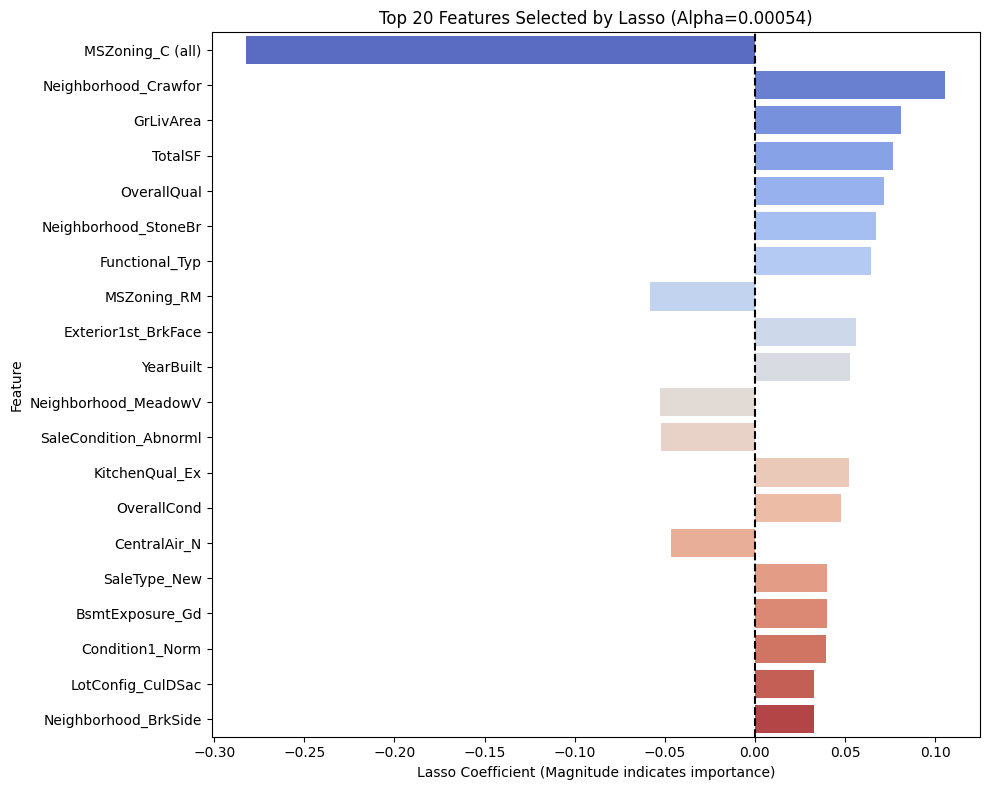

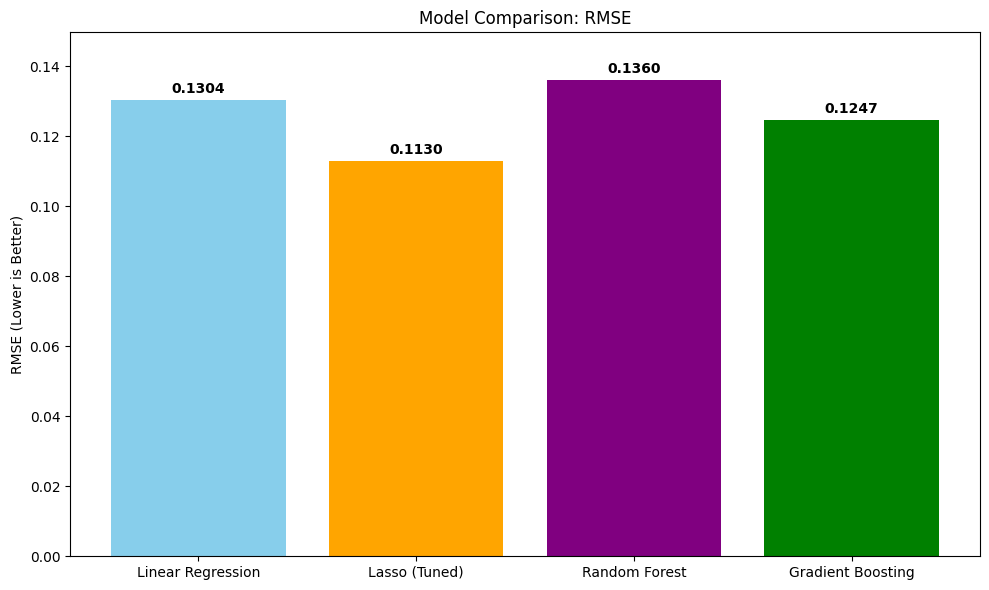

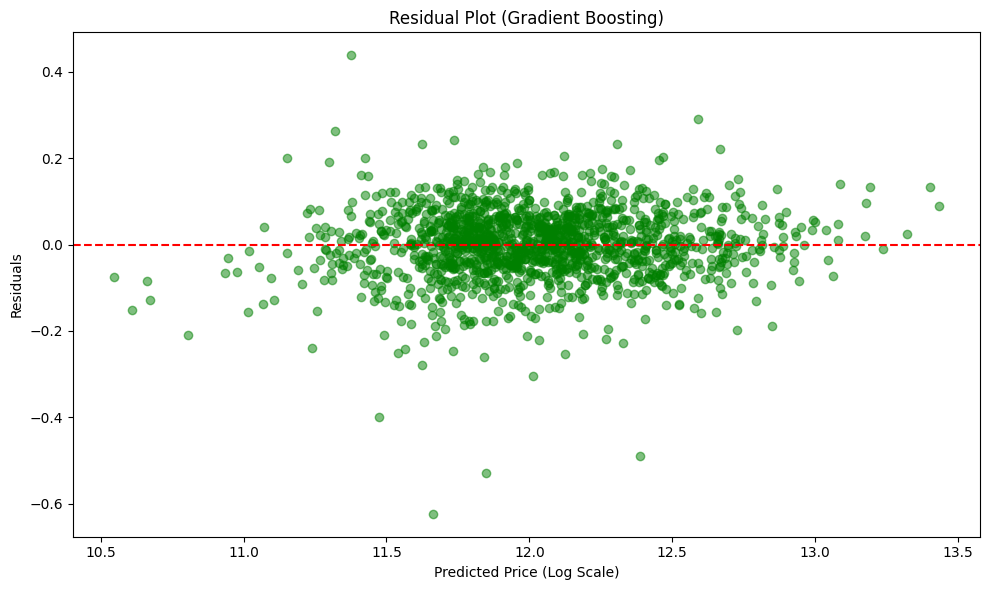

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# --- 1. Load Data & Clean ---
train_df = pd.read_csv('train.csv')

# Remove Outliers (GrLivArea > 4000 & SalePrice < 300000)
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

# Feature Engineering: TotalSF
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

# Log-Transform Target
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(['SalePrice', 'Id'], axis=1)

# --- 2. Preprocessing Pipeline ---
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 3. Lasso Feature Selection ---
print("Running Lasso for Feature Selection...")
# We use LassoCV to automatically find the best alpha (regularization strength)
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lasso)])

lasso_pipeline.fit(X, y)

# Extract Coefficients
best_alpha = lasso_pipeline.named_steps['model'].alpha_
print(f"Best Alpha found: {best_alpha}")

# Get feature names
ohe = lasso_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
feature_names = np.r_[numeric_features, ohe.get_feature_names_out(categorical_features)]
coefficients = lasso_pipeline.named_steps['model'].coef_

# Create DataFrame
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort by absolute coefficient (importance)
top_features_lasso = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)

# --- 4. Model Comparison (including Lasso) ---
models = {
    "Linear Regression": LinearRegression(),
    "Lasso (Tuned)": lasso, # Use the already tuned Lasso
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running Model Comparison...")
for name, model in models.items():
    # Note: For Lasso, we already have a pipeline, but for consistency in the loop
    # we recreate the pipeline structure. LassoCV object 'lasso' is already fitted but
    # cross_val_score will refit it on each fold, which is correct.
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Calculate RMSE
    cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    results[name] = -cv_scores.mean()
    print(f"{name} RMSE: {-cv_scores.mean():.4f}")


# --- 5. Visualizations ---

# Visualization 1: Feature Importance (Lasso)
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=top_features_lasso, palette='coolwarm')
plt.title(f'Top 20 Features Selected by Lasso (Alpha={best_alpha:.5f})')
plt.xlabel('Lasso Coefficient (Magnitude indicates importance)')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('lasso_feature_importance.png')
plt.show()

# Visualization 2: Model Comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['skyblue', 'orange', 'purple', 'green'])
plt.ylabel('RMSE (Lower is Better)')
plt.title('Model Comparison: RMSE')
plt.ylim(0, max(results.values()) * 1.1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.4f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison_final.png')
plt.show()

# Visualization 3: Residual Plot (Gradient Boosting - The Winner)
best_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
final_pipeline.fit(X, y)
y_pred = final_pipeline.predict(X)
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (Gradient Boosting)')
plt.xlabel('Predicted Price (Log Scale)')
plt.ylabel('Residuals')
plt.tight_layout()
plt.savefig('residual_plot_final.png')
plt.show()

Running Lasso for Feature Selection...
Best Alpha found: 0.000537459660257125
Running Model Comparison...
Linear Regression RMSE: 0.1304
Lasso (Tuned) RMSE: 0.1130
Random Forest RMSE: 0.1360
Gradient Boosting RMSE: 0.1247


C:\Users\samwe\AppData\Local\Temp\ipykernel_14668\2823402480.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features_lasso, palette='coolwarm')


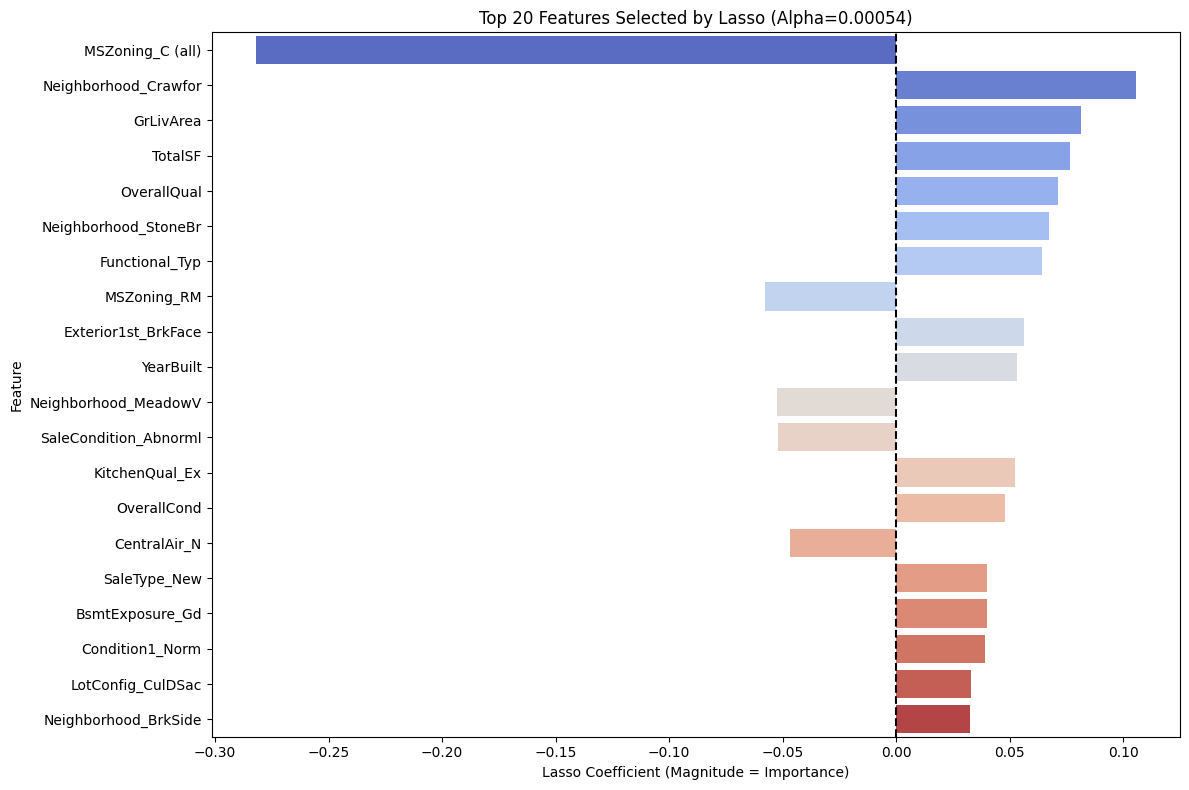

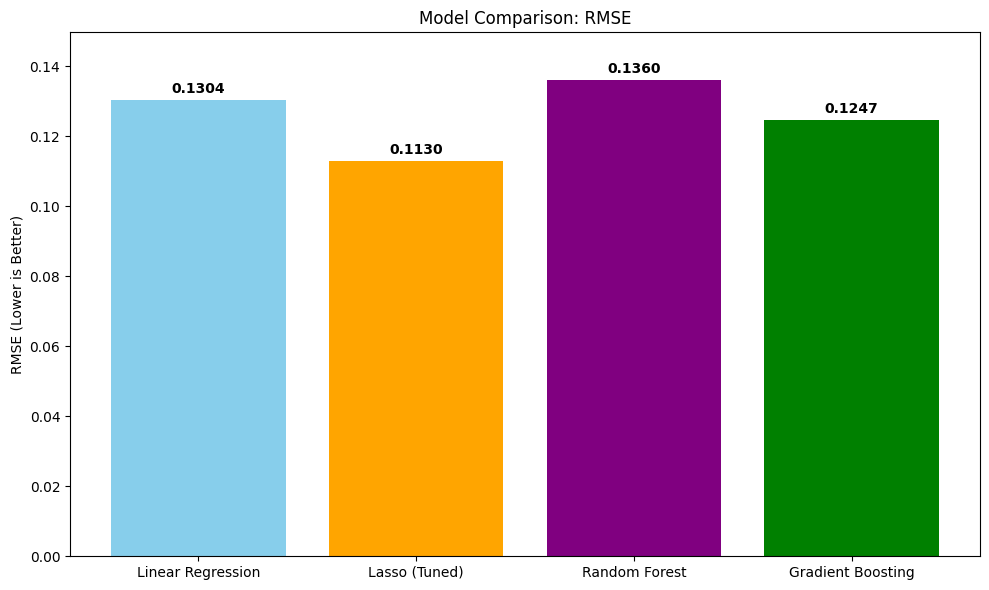

Plotting Residuals for Best Model: Lasso (Tuned)


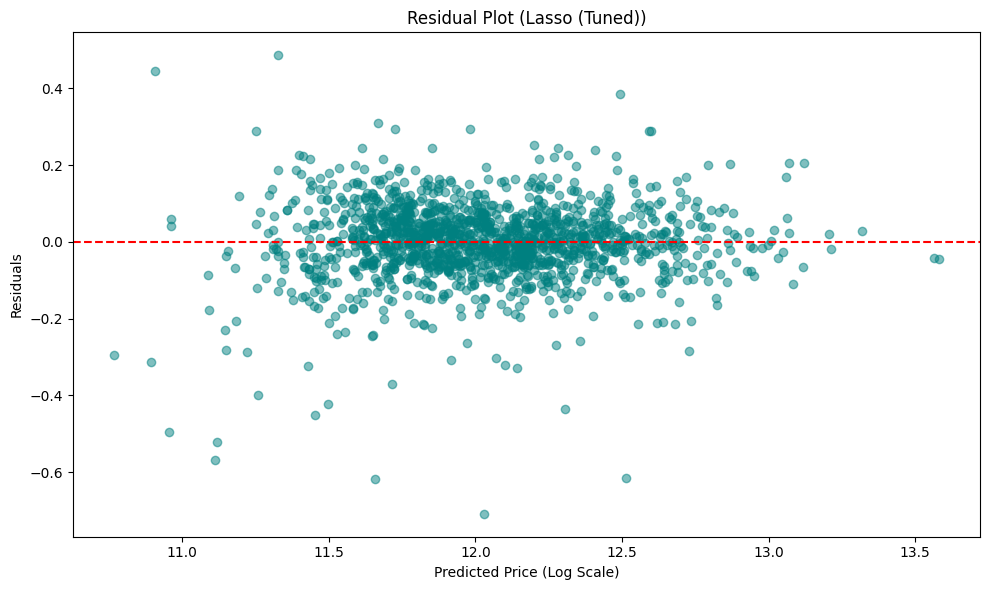

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# --- 1. Load Data & Clean ---
# Load the dataset
train_df = pd.read_csv('train.csv')

# Remove Outliers (GrLivArea > 4000 & SalePrice < 300000)
# These are the "weird" huge houses sold cheaply that confuse the model
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)

# Feature Engineering: Create 'TotalSF' (Total Square Footage)
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

# Log-Transform Target Variable
# This fixes the skewness of SalePrice, making it "Normal"
y = np.log1p(train_df['SalePrice'])
X = train_df.drop(['SalePrice', 'Id'], axis=1)

# --- 2. Preprocessing Pipeline ---
# Define Numeric and Categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Numeric: Fill missing with Median, then Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Fill missing with 'None', then OneHotEncode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine them into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 3. Lasso Feature Selection ---
print("Running Lasso for Feature Selection...")
# LassoCV automatically finds the best 'alpha' (regularization strength)
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', lasso)])

lasso_pipeline.fit(X, y)

# Extract Coefficients to see what matters
best_alpha = lasso_pipeline.named_steps['model'].alpha_
print(f"Best Alpha found: {best_alpha}")

# Get feature names back from the pipeline
ohe = lasso_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
feature_names = np.r_[numeric_features, ohe.get_feature_names_out(categorical_features)]
coefficients = lasso_pipeline.named_steps['model'].coef_

# Create DataFrame of Features
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Sort by importance (Absolute Value of Coefficient)
top_features_lasso = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)

# --- 4. Model Comparison ---
models = {
    "Linear Regression": LinearRegression(),
    "Lasso (Tuned)": lasso, 
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running Model Comparison...")
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # Calculate RMSE (Negative because sklearn maximizes score)
    cv_scores = cross_val_score(clf, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    results[name] = -cv_scores.mean()
    print(f"{name} RMSE: {-cv_scores.mean():.4f}")

# --- 5. Visualizations ---

# Visualization 1: Top 20 Features (Lasso)
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=top_features_lasso, palette='coolwarm')
plt.title(f'Top 20 Features Selected by Lasso (Alpha={best_alpha:.5f})')
plt.xlabel('Lasso Coefficient (Magnitude = Importance)')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Visualization 2: Model Comparison (RMSE)
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['skyblue', 'orange', 'purple', 'green'])
plt.ylabel('RMSE (Lower is Better)')
plt.title('Model Comparison: RMSE')
plt.ylim(0, max(results.values()) * 1.1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.4f}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Visualization 3: Residual Plot (Best Model)
# We re-fit the best model (Lasso or Gradient Boosting) on full data to show residuals
best_model_name = min(results, key=results.get)
best_model_instance = models[best_model_name]
print(f"Plotting Residuals for Best Model: {best_model_name}")

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model_instance)])
final_pipeline.fit(X, y)
y_pred = final_pipeline.predict(X)
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot ({best_model_name})')
plt.xlabel('Predicted Price (Log Scale)')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

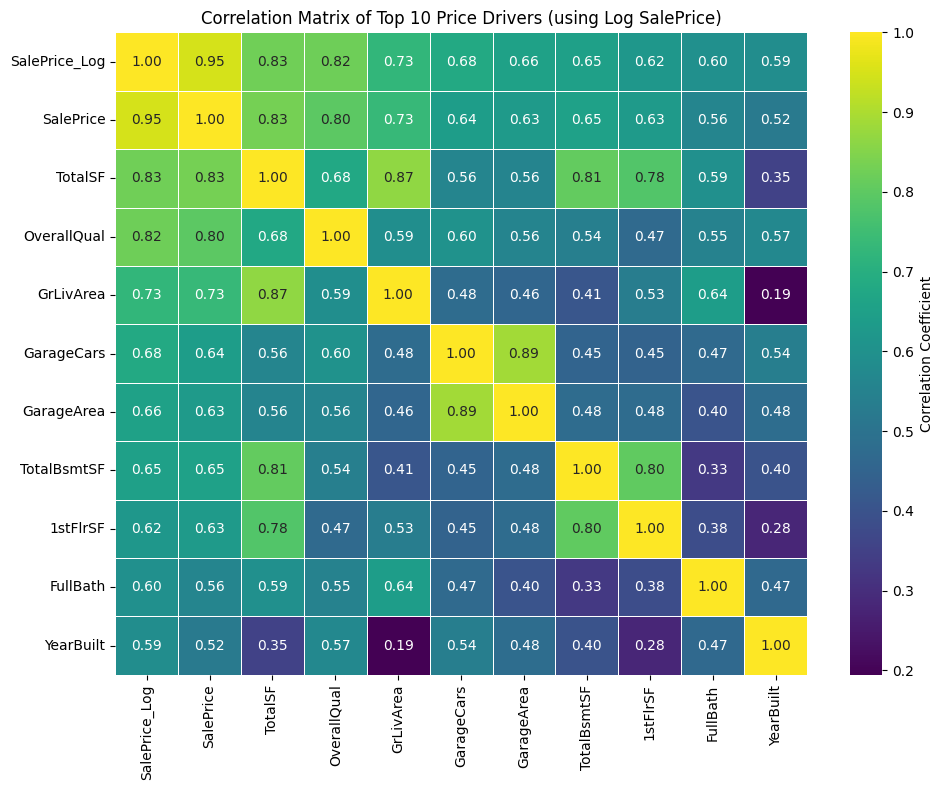

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
train_df = pd.read_csv('train.csv')

# 2. Cleaning & Feature Engineering (as established in previous steps)
# Remove Outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index)
# Engineer TotalSF
train_df['TotalSF'] = train_df['TotalBsmtSF'].fillna(0) + train_df['1stFlrSF'].fillna(0) + train_df['2ndFlrSF'].fillna(0)
# Log-transform target
train_df['SalePrice_Log'] = np.log1p(train_df['SalePrice'])

# 3. Select Numerical Data and Calculate Correlation
# Select only numerical features for correlation calculation
numeric_df = train_df.select_dtypes(include=[np.number])

# Calculate correlation with the log-transformed target variable
correlations = numeric_df.corr()['SalePrice_Log'].sort_values(ascending=False)

# Select the top 11 features (10 features + SalePrice_Log itself)
top_corr_features = correlations[:11].index.tolist()

# 4. Generate Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df[top_corr_features].corr(), 
            annot=True, 
            cmap='viridis', # Use a clear, academic color map
            fmt=".2f", 
            linewidths=.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix of Top 10 Price Drivers (using Log SalePrice)')
plt.tight_layout()
plt.savefig('top_features_correlation_heatmap_final.png')
plt.show()